In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import utils
import geopandas as gpd
import contextily as cx

plt.style.use('seaborn-v0_8-white')

pd.options.mode.copy_on_write = True

URL_DATA = "data.json"

alerts, jams = utils.load_data(URL_DATA)

alerts = utils.filter_location(alerts, utils.PERIM_X, utils.PERIM_Y)
jams = utils.filter_location(jams, utils.PERIM_X, utils.PERIM_Y)


In [22]:
alerts_antof = utils.separate_coords(alerts)

alerts_antof = alerts_antof[['uuid','street', 'type', 'pubMillis', 'endreport', 'x', 'y', 'geometry']]

X_BOUND = [alerts_antof.x.min(), alerts_antof.x.max()]
Y_BOUND = [alerts_antof.y.min(), alerts_antof.y.max()]

Sistema de referencia EPSG estándar para manipulación de datos espaciales en plano web: EPSG:4326 (WGS 84)


Además para mapas en línea se utiliza EPSG:3857 (Pseudo-Mercator), lo que incluye a contextily

In [23]:
alerts_antof.head(3)

,uuid,street,type,pubMillis,endreport,x,y,geometry
0,a123f22e-e5e0-4c6c-8a4e-7434c4fd2110,Av. República de Croacia,HAZARD,1724417637000,1724425125000,-70.412429,-23.676846,POINT (-7838275.742 -2714079.538)
1,1d8df954-e380-4327-8015-f4fbadf74f2d,Av. Edmundo Pérez Zujovic,JAM,1724423878000,1724425125000,-70.392283,-23.617475,POINT (-7836033.099 -2706864.568)
2,c53a5bc6-f6b6-44b8-a5bd-af69b60a4580,Pasaje El Volcán,JAM,1724425406000,1724425125000,-70.385619,-23.573323,POINT (-7835291.266 -2701501.184)


In [24]:
alerts_antof['type'].unique()

array(['HAZARD', 'JAM', 'ACCIDENT', 'ROAD_CLOSED'], dtype=object)

In [25]:
def heat_map(df:gpd.GeoDataFrame, concept:str):

    concepts = {
        'ACCIDENT': 'Accidentes reportados',
        'HAZARD': 'Peligros reportados',
        'JAM': 'Congestión de tráfico reportada'
    }

    event = df.copy()
    event = event[event['type'] == concept]
    event = event[['geometry']]
    event = event.to_crs(epsg=3857) # Para visualización correcta en plano

    fig, ax = plt.subplots()
    fig.set_size_inches((4.5, 9.5))
    sc = event['geometry'].plot(ax=ax, alpha=0.5, cmap='GnBu')
    cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik)
    # Añadir la barra de colores
    cbar = sc.get_figure().colorbar(sc.collections[0], ax=ax)
    cbar.set_label('Frecuencia')
    ax.set_xlabel('Longitud')
    ax.set_ylabel('Latitud')
    plt.xticks(rotation=45)
    plt.title(f'{concepts[concept]}\n Antofagasta', fontweight='bold')
    plt.savefig(f'graph/{concept}_freq_map.png')
    plt.show()



### Mapas de calor donde se muestra la densidad de accidentes, congestión y peligros reportados en la ciudad

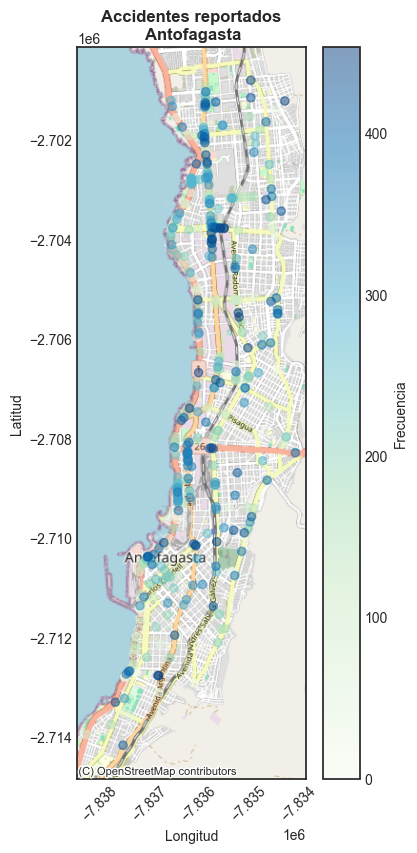

In [26]:
heat_map(alerts_antof, 'ACCIDENT')

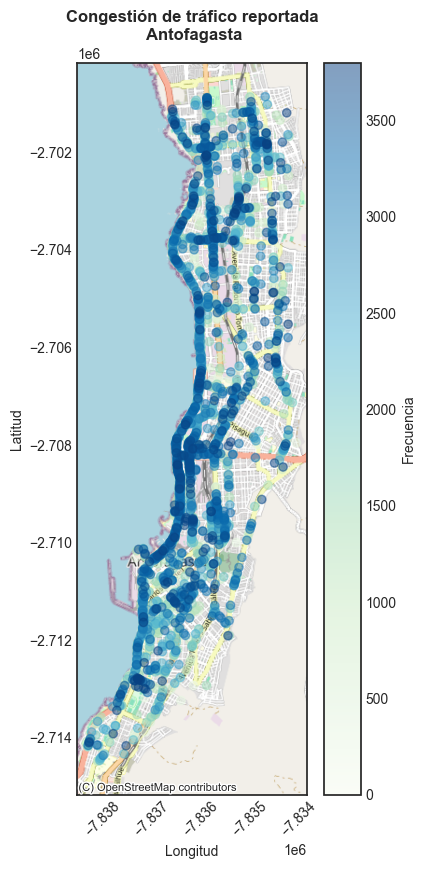

In [27]:
heat_map(alerts_antof, 'JAM')

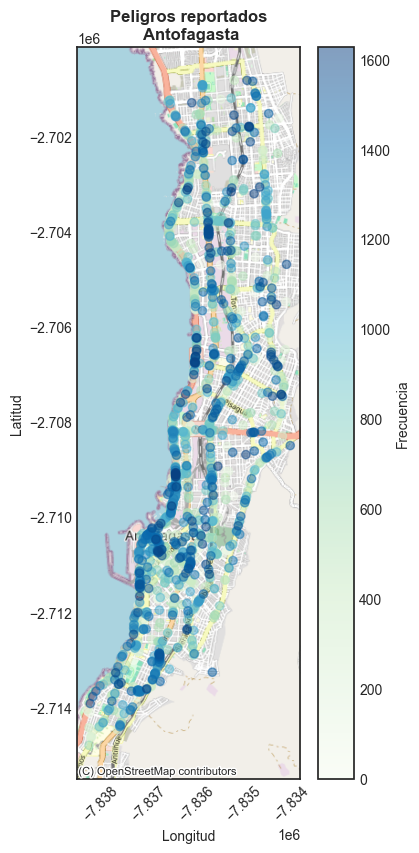

In [28]:
heat_map(alerts_antof, 'HAZARD')

### Evolución de la densidad de accidentes en la ciudad por hora del día

In [29]:

accident = utils.extract_event(alerts_antof, ['ACCIDENT'])
jam = utils.extract_event(alerts_antof, ['JAM'])
hazard = utils.extract_event(alerts_antof, ['HAZARD'])

In [30]:
def day_report(data:gpd.GeoDataFrame, concept:str):
    '''
    Reportes de eventos por día de la semana
    '''
    concepts = {
        'ACCIDENT': 'Accidentes reportados',
        'HAZARD': 'Peligros reportados',
        'JAM': 'Congestión de tráfico reportada'
    }

    hourly_reports = utils.hourly_group(data)

    # Graficar la fluctuación de reportes por hora diferenciando entre semana y fin de semana
    plt.figure(figsize=(10, 6))

    # Ajustar las posiciones de las barras
    bar_width = 0.4
    r1 = np.arange(len(hourly_reports))
    r2 = [x + bar_width for x in r1]

    plt.bar(r1, hourly_reports.loc[:, "s"], color='salmon', width=bar_width, edgecolor='grey', label='Semana')
    plt.bar(r2, hourly_reports.loc[:, "f"], color='skyblue', width=bar_width, edgecolor='grey', label='Fin de Semana / Feriado')

    plt.title(f'{concepts[concept]} durante el día \n (Semana vs. Fin de Semana)')
    plt.xlabel('Hora del día')
    plt.ylabel('Número de reportes')
    
    plt.xticks([r + bar_width / 2 for r in range(len(hourly_reports))], hourly_reports.index)
    plt.grid(True, alpha=0.3)
    plt.legend(loc='upper left')
    plt.savefig(f'graph/{concept}_per_hour.png')
    plt.show()

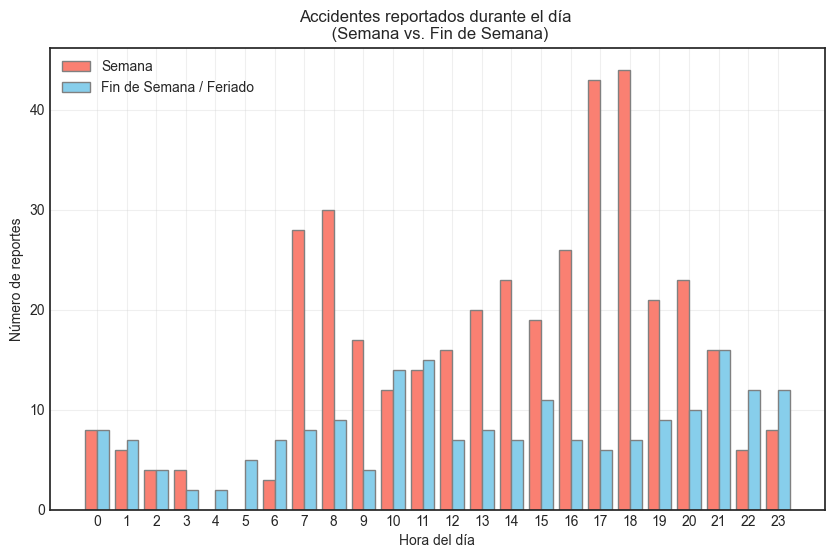

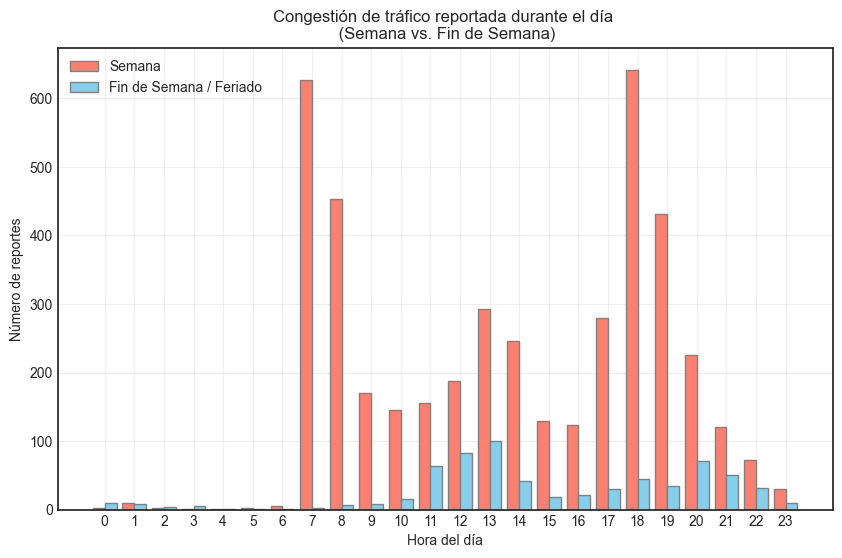

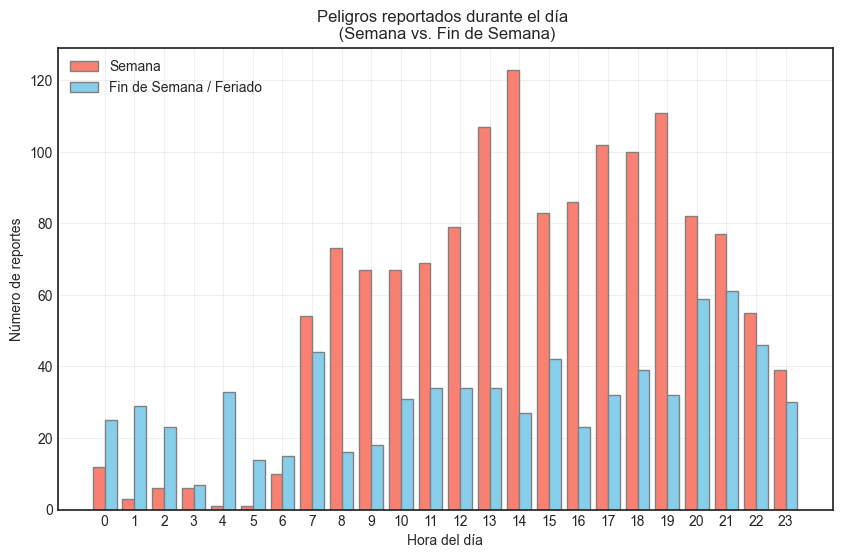

In [31]:
day_report(accident, 'ACCIDENT')
day_report(jam, 'JAM')
day_report(hazard, 'HAZARD')